### Summary of the code - 


1. Data Preparation:

The code reads a CSV file from a URL into a pandas DataFrame (df).
It identifies columns related to media spending (mdsp_cols), control variables (control_vars), and sales (sales_cols).
The relevant columns are selected and stored in the df_main DataFrame.
The data is split into training and testing sets, and scaling is applied to the training data using custom scalers.

2. Model Fitting:

An instance of LightweightMMM is created with the specified model name ("hill_adstock").
The model is fitted to the training data using the fit() method, providing media, target, extra features, and other parameters.

3. Model Summary and Visualization:

A summary of the fitted model is printed using the print_summary() method.
Various plots are generated to visualize the model fit, media channel posteriors, media baseline contribution, ROI, and response curves.

4. Optimization and Budget Allocation:

Prices and budget parameters are set for optimization.
The find_optimal_budgets() function is called to find the optimal budget allocation based on the fitted model and given constraints.
The optimal and previous budget allocations are calculated based on the obtained results.

5. Budget Allocation Comparison:

A comparison plot is generated to visualize the pre- and post-optimization budget allocation and the predicted target variable.

In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro


# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/sibylhe/mmm_stan/main/data.csv")

# 1. media variables
# media spending (Simplified media channel for demo)
mdsp_cols=[col for col in df.columns if 'mdsp_' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']

# 2. control variables
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]

control_vars =  hldy_cols + seas_cols

# 3. sales variables
sales_cols =['sales']

df_main = df[['wk_strt_dt']+sales_cols+mdsp_cols+control_vars]
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]

In [3]:
df_main.head()

,wk_strt_dt,sales,Direct Mail,Insert,Newspaper,Radio,TV,Social Media,Online Display,hldy_Black Friday,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,72051457.64,678410.26,129759.66,507635.16,254134.14,216725.59,0.0,61364.75,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,78794770.54,661097.71,70355.33,625719.37,106602.98,108919.26,0.0,132643.90,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,70071185.56,1874338.43,107720.37,277532.61,59011.42,74032.19,0.0,76741.27,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,68642464.59,306583.37,141708.61,186028.61,178010.46,110995.66,0.0,193043.55,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,86190784.65,2366274.16,160691.30,706694.09,144097.56,225140.84,0.0,249612.89,0,...,0,0,0,0,0,0,0,0,0,0


### Data Preprocessing

In [4]:
SEED = 105
data_size = len(df_main)

n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['sales'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

# Split and scale data.
test_data_period_size = 24
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

Also, this library provides a CustomScaler function for preprocessing. In this sample code, we divide the media spending data, extra features data, and the target data by their mean to ensure that the result has a mean of 1. This allows the model to be agnostic to the scale of the inputs

In [5]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [6]:
media_data_train.shape

(185, 7)

In [7]:
target_train.shape

(185,)

In [8]:
costs.shape

(7,)

### Training - choose from 3 stock functions for modelling (Hill stock, Ad stock, Carryover)

In [9]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
number_warmup=1000
number_samples=1000
mmm.fit( media=media_data_train, media_prior=costs, target=target_train, extra_features=extra_features_train, number_warmup=number_warmup, number_samples=number_samples, media_names = mdsp_cols, seed=SEED)

/Users/rachitasingh/anaconda3/envs/myenv/lib/python3.11/site-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|█| 2000/2000 [01:20<00:00, 24.69it/s, 1023 steps of size 1.97e-03. 
sample: 100%|█| 2000/2000 [01:20<00:00, 24.89it/s, 1023 steps of size 1.98e-03. 


r-hat values should be less than 1.1 for all parameters. This a checkpoint for Bayesian modelling.

In [10]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.03      0.85      0.04     -1.28      1.45    454.17      1.00
             coef_extra_features[1]      0.10      0.70      0.11     -1.08      1.19    306.47      1.00
             coef_extra_features[2]     -0.01      0.01     -0.01     -0.03     -0.00    435.58      1.01
             coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01    931.04      1.00
             coef_extra_features[4]     -0.06      0.71     -0.08     -1.26      1.11    330.20      1.00
             coef_extra_features[5]     -0.08      0.70     -0.10     -1.17      1.09    307.18      1.00
             coef_extra_features[6]     -0.01      0.00     -0.01     -0.01     -0.00   1663.41      1.00
             coef_extra_features[7]     -0.00      0.00     -0.00     -0.01      0.00   1177.74      1.00
             coef_extra_features[8]     -0.02

#### The media effects plot shows an estimate of the coefficients for each media channel. High numbers mean the channel influenced the revenue more.

#### The x-axis is the estimated coefficient, the y-axis can be seen as how confident the model is that the x-axis value is the right value for the media effect.

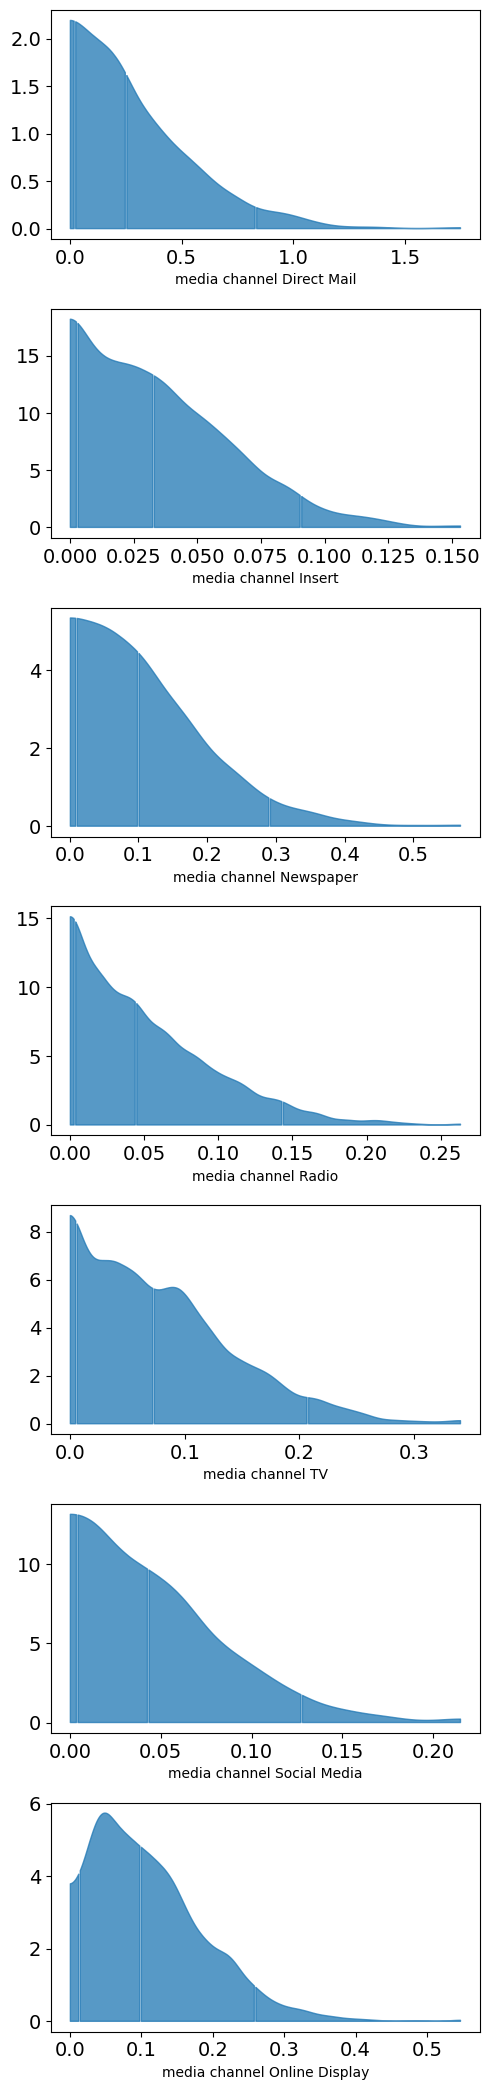

In [11]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)

Now, let’s do a fitting check. The model’s fit to the training data can also be checked by using plot_model_fit function. R-squared and MAPE, mean absolute percentage error, are shown in the chart. In this example, R2 is 0.7, and MAPE is 23%. Generally speaking, R2 is considered good if it is more than 0.8. Also, for MAPE, the goal is for it to be 20% or below.

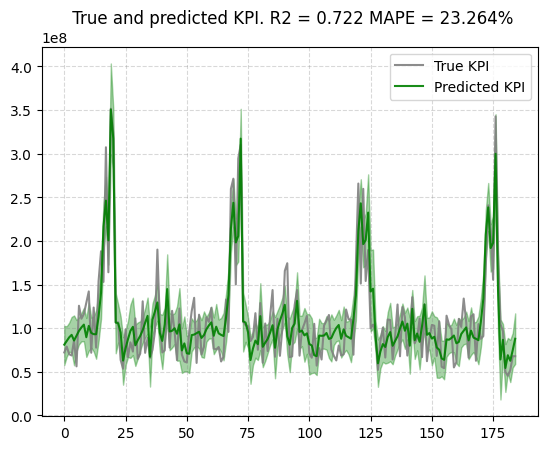

In [12]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

### Media insights - visualising estimated media and baseline contribution over time

In [13]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)    

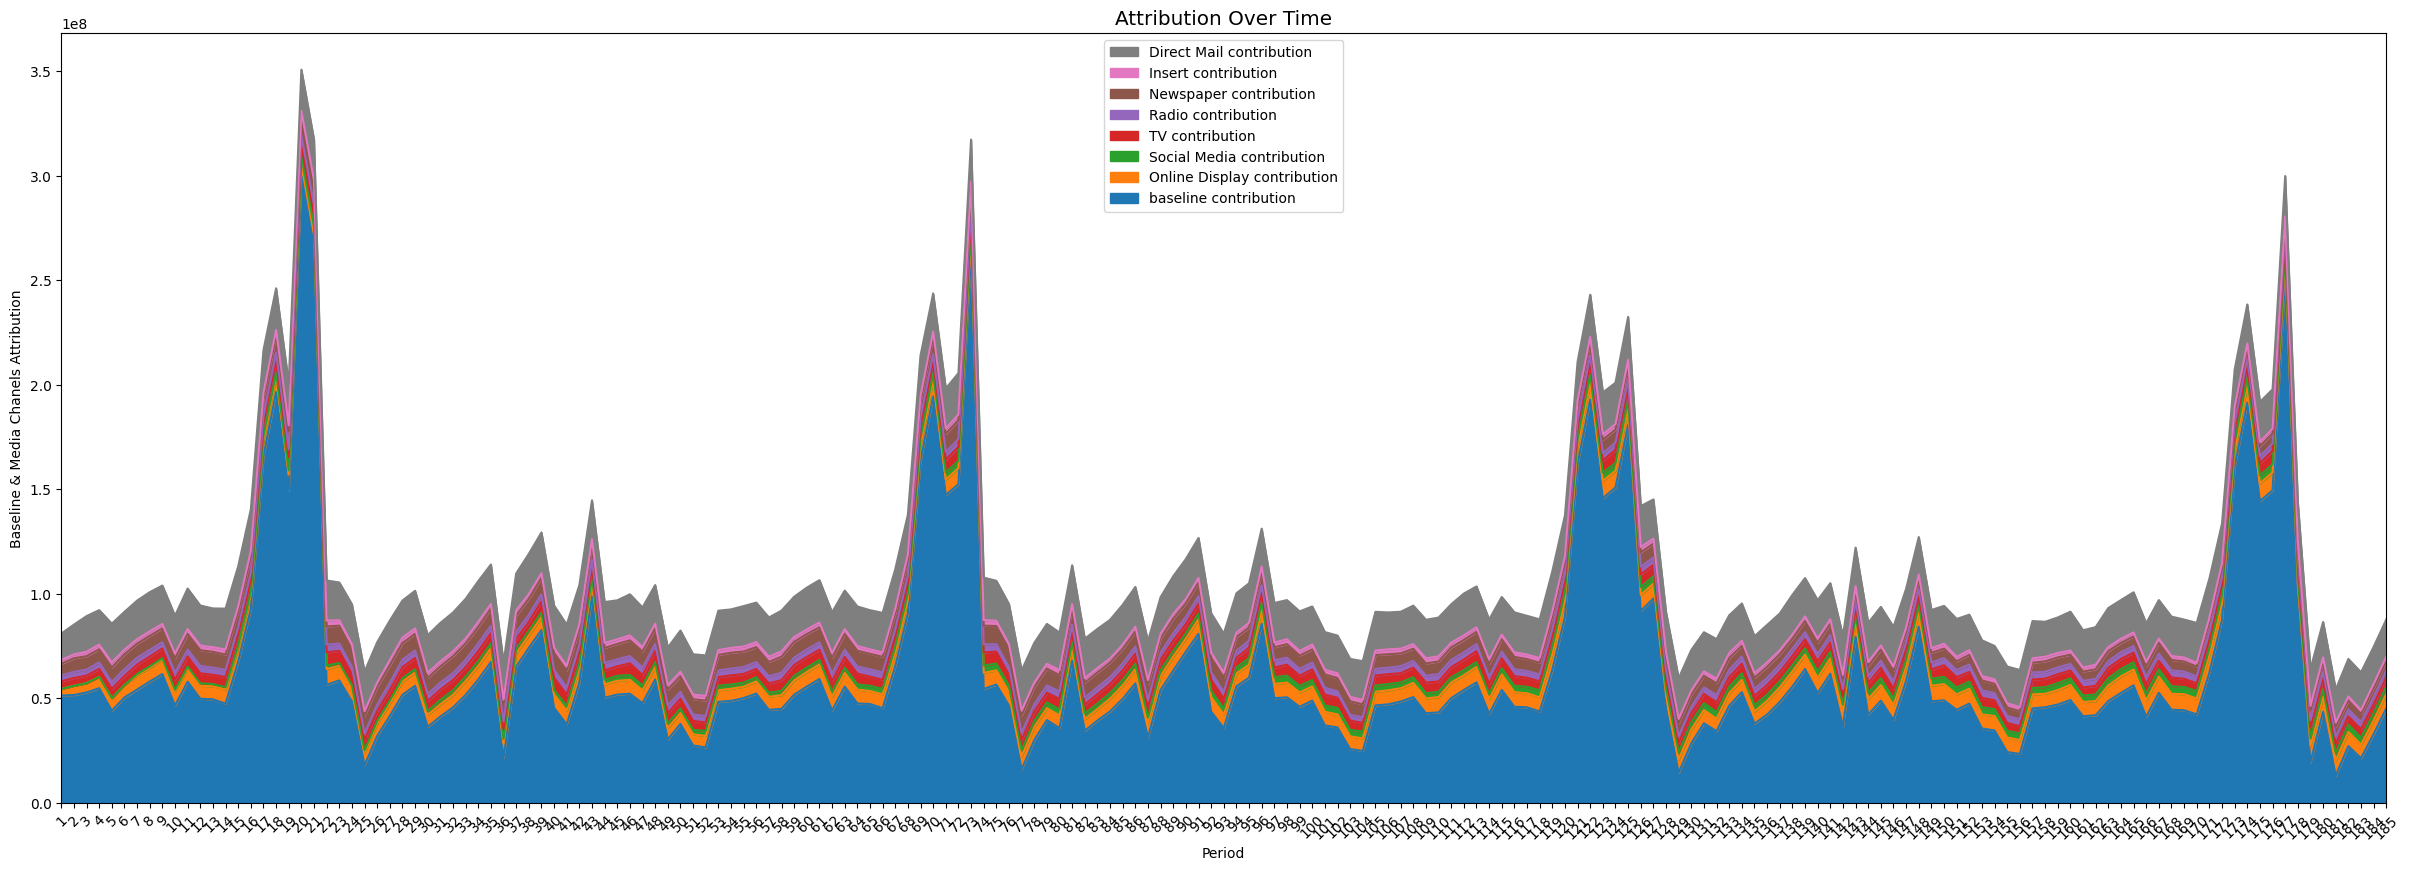

In [14]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = mdsp_cols
                                                )

#### Visualising the estimated media contributions with their respective credibility intervals

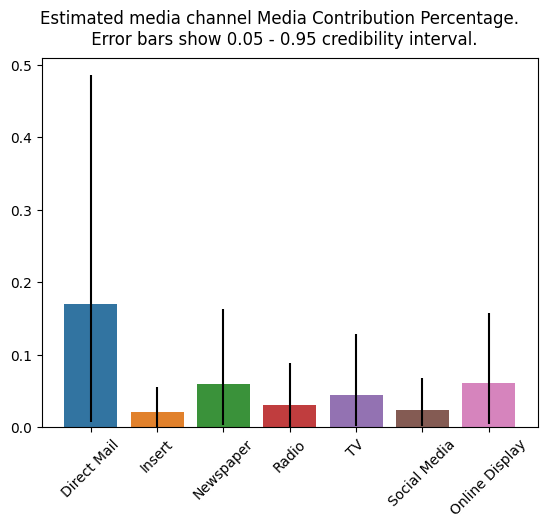

In [15]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=mdsp_cols)

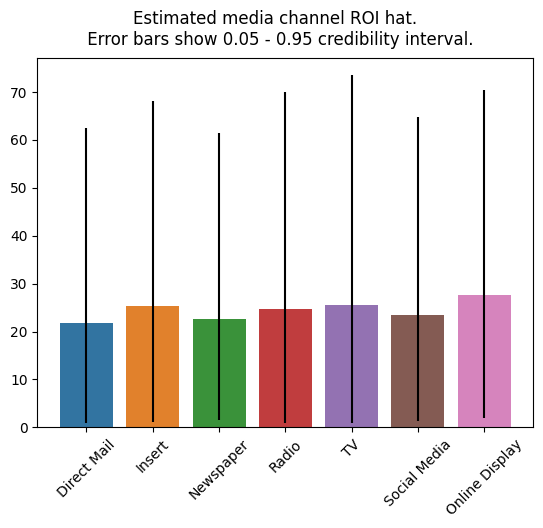

In [16]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=mdsp_cols)

Another vital question we can solve with MMMs is how each media channel behaves individually as we invest more in it.

For that we can plot the curve response of all media channels with the following function:

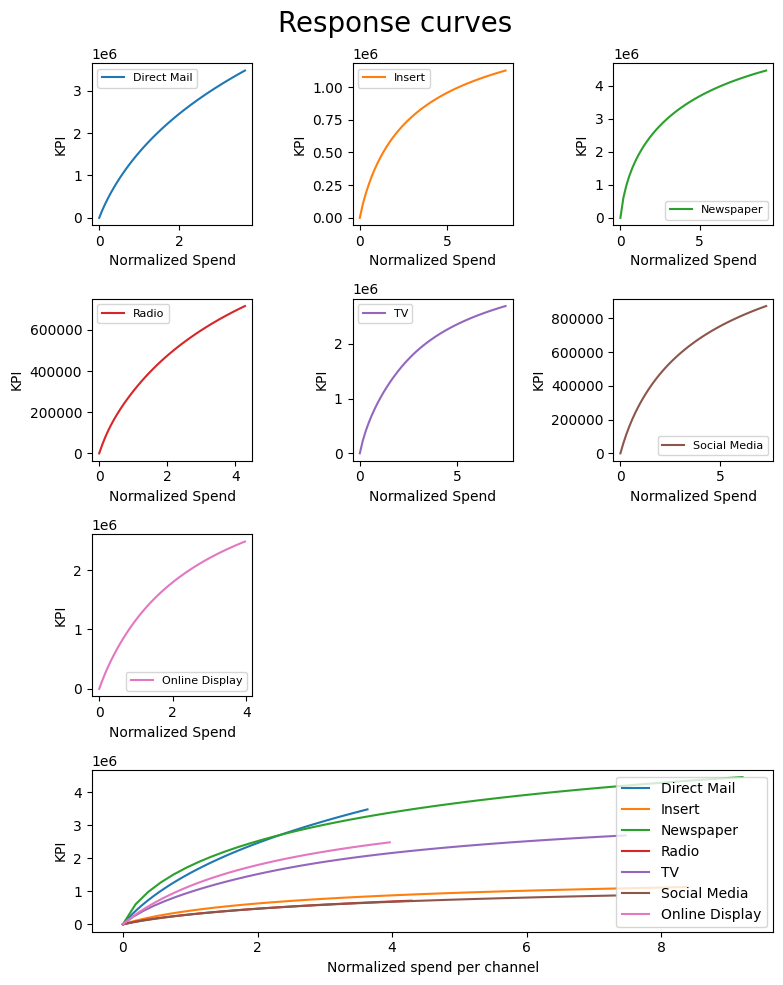

In [17]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

### Optimisation

The optimization is meant to solve the budget allocation questions for you. First you need to provide for how long you want to optimize your budget (eg. 15 weeks in this case).

The optimization values will be bounded by +- 20% of the max and min historic values used for training. Which means the optimization won't recommend to completely change your strategy but how to make some budget re-allocation.

You can change that percentage with the following parameters: - bounds_lower_pct - bounds_upper_pct

Which can hold 1 value for all channels or 1 value per channel.

Prices are the average price you would expect for the media units of each channel. If your data is already a money unit (eg. $) your prices should be an array of 1s.

The budget is how much one would like to allocate throughtout the total of n_time_periods. Make sure this amount is inline with the historic spend or otherwise some conditions/bounds in the optimization might not be met.

In [18]:
prices = jnp.ones(mmm.n_media_channels)

In [19]:
n_time_periods = 20
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [20]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Iteration limit reached    (Exit mode 9)
            Current function value: -2033375486.3901327
            Iterations: 200
            Function evaluations: 4072
            Gradient evaluations: 197


In [21]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([12732954. ,  1957355.6,  5649243. ,  2119516.5,  4242602.5,
        2253508.5,  5053708. ], dtype=float32)

In [22]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([15288896. ,  1625417.5,  5506312.5,  2342750.2,  3396159.2,
        1803910.1,  4045440.8], dtype=float32)

In [23]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(34008888., dtype=float32), Array(34008888., dtype=float32))

In [24]:
#we can double check if the budget constraint was met

# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(34008888., dtype=float32), Array(34008888., dtype=float32))

#### Pre post optimization budget allocation comparison for each channel and predicted target variable comparison

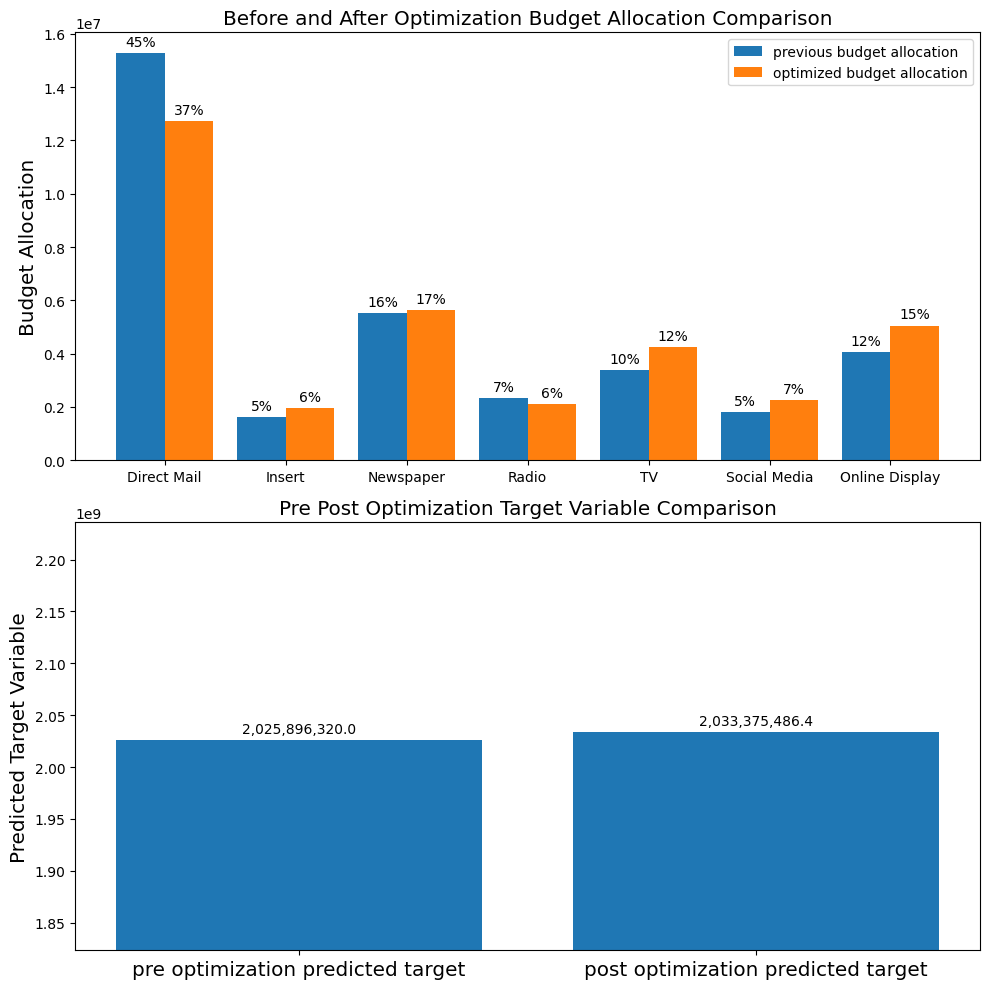

In [25]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10),
                                                channel_names = mdsp_cols)
     